# Testing DEMV on _Contraceptive Method Choice_ dataset

Source: [https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice)

- Label: `contr_use`
- Unprivileged group: `wife_religion=1 (islam) & wife_work=1 (non-work)`
- Positive label: `2 (long-term)`

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv('data2/cmc.data', names=['wife_age', 'wife_edu', 'hus_edu', 'num_child', 'wife_religion', 'wife_work', 'hus_occ', 'living', 'media', 'contr_use'])
data

,wife_age,wife_edu,hus_edu,num_child,wife_religion,wife_work,hus_occ,living,media,contr_use
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


In [3]:
label = 'contr_use'
sensitive_features = ['wife_religion', 'wife_work']
unpriv_group = {'wife_religion': 1, 'wife_work': 1}
positive_label= 2

In [4]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

In [5]:
data

,wife_age,wife_edu,hus_edu,num_child,wife_religion,wife_work,hus_occ,living,media,contr_use
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


## Biased dataset

In [6]:
model, bias_metrics = cross_val(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)

In [7]:
print_metrics(bias_metrics)

Equalized odds:  0.219  +-  0.112
Disparate impact:  0.494  +-  0.121
Zero one loss:  0.33  +-  0.147
Accuracy score:  0.521  +-  0.038


## DEMV dataset

In [8]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [9]:
model, demv_metrics = cross_val(pipeline, demv_data, label, unpriv_group, sensitive_features, debiaser=demv, positive_label=positive_label)

In [10]:
print_metrics(demv_metrics)

Equalized odds:  0.203  +-  0.186
Disparate impact:  0.67  +-  0.173
Zero one loss:  0.228  +-  0.115
Accuracy score:  0.512  +-  0.038


## DEMV Evaluation

In [11]:
eval_data = data.copy()

In [12]:
demv.get_iters()

15

In [13]:
metrics = eval_demv(3, demv.get_iters(), eval_data, pipeline, label, unpriv_group, sensitive_features, positive_label)

Execution time: ~6min

## Blackbox PostProcessing

In [14]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)


Pre-adjustment group rates are 

0
      fpr     tpr
1  0.3889  0.6923
2  0.0952  0.3000
3  0.3478  0.2500

1
      fpr     tpr
1  0.3857  0.6809
2  0.0729  0.3333
3  0.2500  0.5510


And loss is 0.4595


Pre-adjustment group rates are 

0
      fpr   tpr
1  0.3889  0.70
2  0.1111  0.30
3  0.3500  0.25

1
      fpr     tpr
1  0.3857  0.6571
2  0.0714  0.3333
3  0.2679  0.5510


And loss is 0.4812

[0.6576971  0.33272435 0.00957855]
[0.31745638 0.37843853 0.30410509]
[0.47446604 0.26869214 0.25684182]
[0.6576971  0.20521017 0.13709273]
[0.43180451 0.37843853 0.18975697]
[0.36813871 0.37501947 0.25684182]

Pre-adjustment group rates are 

0
      fpr     tpr
1  0.3889  0.6667
2  0.1176  0.3000
3  0.3684  0.2500

1
      fpr     tpr
1  0.3857  0.6667
2  0.0706  0.3333
3  0.2632  0.5510


And loss is 0.4812

[6.42442913e-01 3.57557087e-01 6.89502010e-11]
[0.28909931 0.41433866 0.29656203]
[0.48183218 0.27103279 0.24713503]
[0.64244291 0.21078341 0.14677368]
[0.41361332 0.41433866 0.172048

## Plot

In [15]:
df = prepareplots(metrics,'cmc')

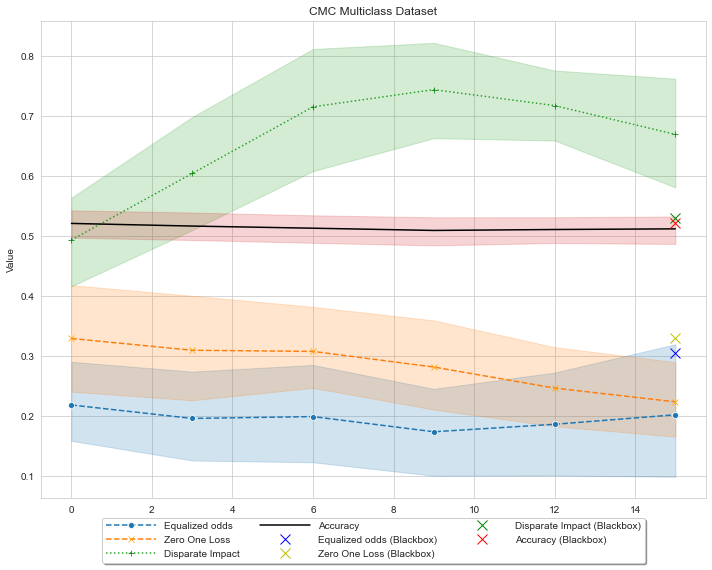

In [16]:
points = preparepoints(blackboxmetrics, demv.get_iters())
plot_metrics_curves(df, points, title='CMC Multiclass Dataset')

In [17]:
unprivpergentage(data,unpriv_group, demv.get_iters())

Dataset size: 1473
Unprivileged group size: 955
Percentage of unprivileged group: 64.8336727766463
Number of iterations: 15


In [18]:
blackboxmetrics

{'eq_odds': [[0.4105653382761817],
  [0.5],
  [0.2916666666666667],
  [0.10463061152350653],
  [0.4525862068965517],
  [0.5347222222222222],
  [0.19646664636003652],
  [0.09999999999999999],
  [0.10294117647058826],
  [0.3666666666666667]],
 'zero_one_loss': [[0.5862068965517242],
  [0.4340277777777778],
  [0.2777777777777778],
  [0.3307692307692308],
  [0.05555555555555558],
  [0.15714285714285714],
  [0.3508771929824561],
  [0.3563829787234043],
  [0.48750000000000004],
  [0.2597402597402597]],
 'disp_imp': [[0.49358974358974356],
  [0.3522727272727273],
  [0.9395604395604397],
  [0.6971677559912854],
  [0.4892648015614834],
  [0.13445378151260504],
  [0.4739583333333333],
  [0.7094339622641509],
  [0.4564705882352942],
  [0.5499999999999999]],
 'acc': [[0.5405405405405406],
  [0.5202702702702703],
  [0.5540540540540541],
  [0.43537414965986393],
  [0.5238095238095238],
  [0.54421768707483],
  [0.54421768707483],
  [0.48299319727891155],
  [0.5714285714285714],
  [0.4965986394557823]

In [19]:
save_metrics('blackbox', 'cmc', blackboxmetrics)